# Dependencies

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     cross_val_score,
                                     GridSearchCV,
                                    RandomizedSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              RandomForestClassifier, 
                              ExtraTreesClassifier)

from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             accuracy_score)

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from tqdm import tqdm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

# Process Data

In [2]:
dataset = read_csv('./data/creditcard.csv')

In [4]:
# shape
dataset.shape

(284807, 31)

In [5]:
dataset.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
set(dataset.dtypes.to_list())

{dtype('int64'), dtype('float64')}

In [12]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [3]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(dataset.Class.value_counts().rename(index = class_names))

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64


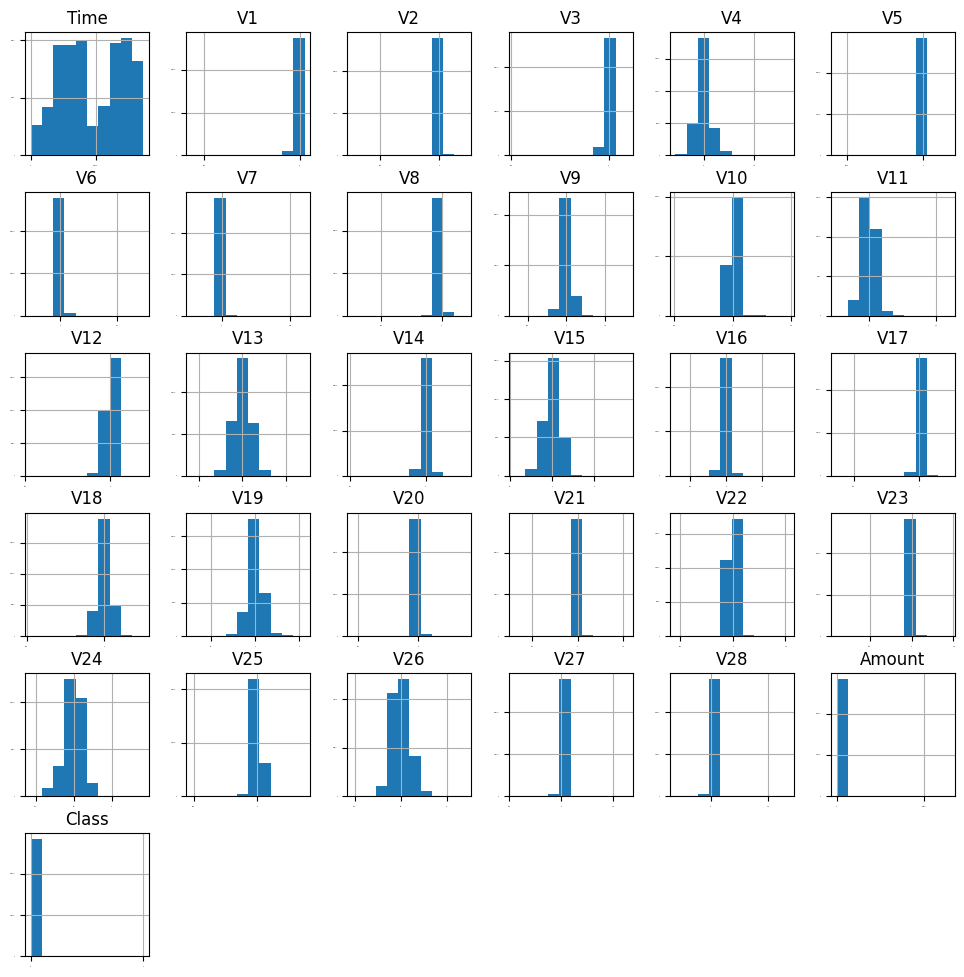

In [19]:
# histograms
dataset.hist(sharex=False,
             sharey=False,
             xlabelsize=1,
             ylabelsize=1,
             figsize=(12,12))
plt.show()

# Training

## Stratified Split

In [4]:
df_train, df_test = train_test_split(dataset,
                                     test_size=.2,
                                     stratify = dataset.Class)

In [5]:
bestfeatures = SelectKBest(k=10)

Y_train, Y_test = df_train["Class"], df_test["Class"]
X_train = df_train.drop(columns = ["Class"])
X_test = df_test.drop(columns = ["Class"])

In [7]:
fit = bestfeatures.fit(X_train,Y_train)

df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)
 
feature_Scores = pd.concat([df_columns,df_scores],axis=1)
feature_Scores.columns = ['Specs','Score']  #naming the dataframe columns
print(feature_Scores.nlargest(10,'Score'))  #print 10 best features

   Specs         Score
17   V17  25912.118042
14   V14  23682.150780
12   V12  16344.182705
10   V10  10442.170960
16   V16   8903.894890
3     V3   8246.769894
7     V7   7148.974773
11   V11   5687.242768
4     V4   3996.957881
18   V18   2673.686253


In [8]:
num_folds = 10

In [82]:
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))

# # Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))

In [83]:
results = []
names = []
scoring = 'recall'
seed = 123

for name, model in tqdm(models):
    kfold = StratifiedShuffleSplit(n_splits=num_folds,
                                   random_state=seed)
    
    cv_results = cross_val_score(model,
                                 X_train,
                                 Y_train, 
                                 cv=kfold, 
                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

 10%|████▍                                       | 1/10 [00:11<01:47, 11.93s/it]

LR: 0.689744 (0.086915)


 20%|████████▊                                   | 2/10 [00:16<01:03,  7.89s/it]

LDA: 0.779487 (0.064051)


 30%|█████████████▏                              | 3/10 [02:29<07:34, 64.97s/it]

CART: 0.789744 (0.061538)


 40%|█████████████████▌                          | 4/10 [02:30<03:58, 39.69s/it]

NB: 0.671795 (0.060461)


 50%|██████████████████████                      | 5/10 [03:41<04:14, 50.99s/it]

SVM: 0.000000 (0.000000)


 60%|█████████████████████████▊                 | 6/10 [20:16<24:47, 371.79s/it]

NN: 0.558974 (0.299858)


 70%|██████████████████████████████             | 7/10 [41:48<33:37, 672.63s/it]

RF: 0.805128 (0.055232)


 80%|██████████████████████████████████▍        | 8/10 [43:06<16:06, 483.41s/it]

ET: 0.807692 (0.054090)


 90%|██████████████████████████████████████▋    | 9/10 [49:27<07:31, 451.43s/it]

AB: 0.700000 (0.048718)


100%|████████████████████████████████████████| 10/10 [1:27:32<00:00, 525.27s/it]

GBM: 0.461538 (0.245673)


array([2.19827567e-06, 2.19827567e-06, 2.19827567e-06, ...,
       2.19827567e-06, 2.19827567e-06, 2.19827567e-06])

# Reweighting

In [9]:
wghts = np.zeros(Y_train.shape[0])
wghts[Y_train==1] = 1/788.
wghts[Y_train==0] = 1/454902.

In [10]:
models = []

models.append(('LR', LogisticRegression()))

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network

# # Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))

In [11]:
results = []
names = []
scoring = 'recall'
seed = 123

for name, model in tqdm(models):
    kfold = StratifiedShuffleSplit(n_splits=num_folds,
                                   random_state=seed)
    
    cv_results = cross_val_score(model,
                                 X_train,
                                 Y_train, 
                                 cv=kfold, 
                                 scoring=scoring,
                                 fit_params={'sample_weight':wghts})
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

 14%|██████▍                                      | 1/7 [00:06<00:37,  6.24s/it]

LR: 0.841026 (0.029902)


 29%|████████████▊                                | 2/7 [01:13<03:31, 42.24s/it]

CART: 0.717949 (0.052548)


 43%|███████████████████▎                         | 3/7 [01:14<01:33, 23.42s/it]

NB: 0.769231 (0.052548)


 57%|█████████████████████████▏                  | 4/7 [12:24<13:55, 278.66s/it]

RF: 0.769231 (0.041345)


 71%|███████████████████████████████▍            | 5/7 [13:36<06:47, 203.98s/it]

ET: 0.764103 (0.059363)


 86%|█████████████████████████████████████▋      | 6/7 [19:55<04:23, 263.46s/it]

AB: 0.874359 (0.026770)


100%|████████████████████████████████████████████| 7/7 [54:42<00:00, 468.90s/it]

GBM: 0.869231 (0.035251)


## Downsampling

In [126]:
df_train, df_test = train_test_split(dataset,
                                     test_size=.2,
                                     stratify = dataset.Class)

num_non_fraud = (df_train['Class']==0).sum()
num_fraud = (df_train['Class']==1).sum()

random_fraud_idx = np.random.choice(np.arange(num_non_fraud),num_fraud)
fraud_df = df_train.loc[df_train['Class'] == 1]
non_fraud_df = df_train.loc[df_train['Class'] == 0].iloc[random_fraud_idx,:]

df_downsampled = pd.concat([fraud_df, non_fraud_df])
df_downsampled = df_downsampled.sample(frac=1, random_state=123)

In [131]:
test_idxs = list(set(dataset.index)-set(Y_train_new.index))

Y_train_new = df_downsampled["Class"]
X_train_new = df_downsampled.drop(columns=['Class'])

Y_test_new = dataset.loc[test_idxs,'Class']
X_test_new = dataset.loc[test_idxs,dataset.columns != 'Class'] 

In [132]:
scoring='accuracy'
# spot-check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
# Ensemble Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier())) # Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [133]:
results = []
names = []
scoring = 'recall'
seed = 123

for name, model in tqdm(models):
    kfold = StratifiedShuffleSplit(n_splits=num_folds,
                                   random_state=seed)
    
    cv_results = cross_val_score(model,
                                 X_train_new,
                                 Y_train_new, 
                                 cv=kfold, 
                                 scoring=scoring)
    
    
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

 10%|████▍                                       | 1/10 [00:00<00:01,  6.88it/s]

LR: 0.895513 (0.064191)


 30%|█████████████▏                              | 3/10 [00:00<00:01,  5.11it/s]

LDA: 0.837179 (0.052338)
CART: 0.898077 (0.030678)
NB: 0.712051 (0.087459)


 50%|██████████████████████                      | 5/10 [00:00<00:00,  6.28it/s]

SVM: 0.658910 (0.070363)


 60%|██████████████████████████▍                 | 6/10 [00:14<00:16,  4.06s/it]

NN: 0.657179 (0.344266)


 70%|██████████████████████████████▊             | 7/10 [00:15<00:09,  3.23s/it]

AB: 0.903013 (0.060511)


 80%|███████████████████████████████████▏        | 8/10 [00:20<00:07,  3.77s/it]

GBM: 0.910833 (0.046323)


 90%|███████████████████████████████████████▌    | 9/10 [00:22<00:03,  3.13s/it]

RF: 0.898205 (0.034327)


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.31s/it]

ET: 0.900577 (0.049467)


In [154]:
results = {}
scoring = 'recall'
seed = 123

for name, model in tqdm(models):
    
    mdl = model.fit(X_train_new,Y_train_new)
    
    rec = (sklearn.metrics.recall_score(mdl.predict(X_test),
                             Y_test))
    
    acc = (sklearn.metrics.accuracy_score(mdl.predict(X_test),
                             Y_test))
    
    results[name] = cv_results
    
    msg = "%s: %f (%f)" % (name, rec, acc)
    print(msg)

 30%|█████████████▏                              | 3/10 [00:00<00:00, 29.17it/s]

LR: 0.035326 (0.956252)
LDA: 0.057679 (0.975124)
CART: 0.013978 (0.881079)
NB: 0.088164 (0.986307)
SVM: 0.002319 (0.455707)


 60%|██████████████████████████▍                 | 6/10 [00:06<00:05,  1.25s/it]

NN: 0.001735 (0.010130)
AB: 0.029794 (0.946192)


 80%|███████████████████████████████████▏        | 8/10 [00:07<00:02,  1.02s/it]

GBM: 0.033684 (0.951617)


 90%|███████████████████████████████████████▌    | 9/10 [00:08<00:00,  1.07it/s]

RF: 0.040546 (0.960482)


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.11it/s]

ET: 0.059043 (0.973368)


In [151]:
names

['LR', 'LDA', 'CART', 'NB', 'SVM', 'NN', 'AB', 'GBM', 'RF', 'ET']